In [1]:
import torch
import torchvision
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_directory = "archive/Training"
test_directory = "archive/Testing"

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.ImageFolder(root=train_directory, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        # Rearrange batch to be the shape of [B, C, W * H]
        images = images.view(images.size(0), images.size(1), -1)
        # Update total number of images
        total_images_count += images.size(0)
        # Compute mean and std here
        mean += images.mean(2).sum(0) 
        std += images.std(2).sum(0)

    # Final step
    mean /= total_images_count
    std /= total_images_count

    return mean, std

mean, std = calculate_mean_std(loader)
print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.1794, 0.1794, 0.1794])
Std: tensor([0.1723, 0.1723, 0.1723])


----

In [4]:
# PyTorch transform image set up

transform_train = torchvision.transforms.Compose([
    # Resize all images to 224 x 224 pixel image
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.RandomRotation(10),
    
    # Give the image a random crop
    torchvision.transforms.RandomResizedCrop(size=(224,224), scale=(0.8,1.0), ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean.tolist(),std=std.tolist())
])


transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean.tolist(),std=std.tolist())
])

In [5]:
# Import images
train_dataset = DataLoader(torchvision.datasets.ImageFolder(root=train_directory, transform=transform_train),
                           batch_size=16, shuffle=True)
test_dataset = DataLoader(torchvision.datasets.ImageFolder(root=test_directory, transform=transform_test),
                          batch_size=16, shuffle=True)

In [6]:
# Show Transformed Images

def show_transformed_images(dataset):
    loader = dataset
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 3, 3, 3, 3, 2, 1, 1, 1, 3, 0, 1, 1, 2, 1, 1])


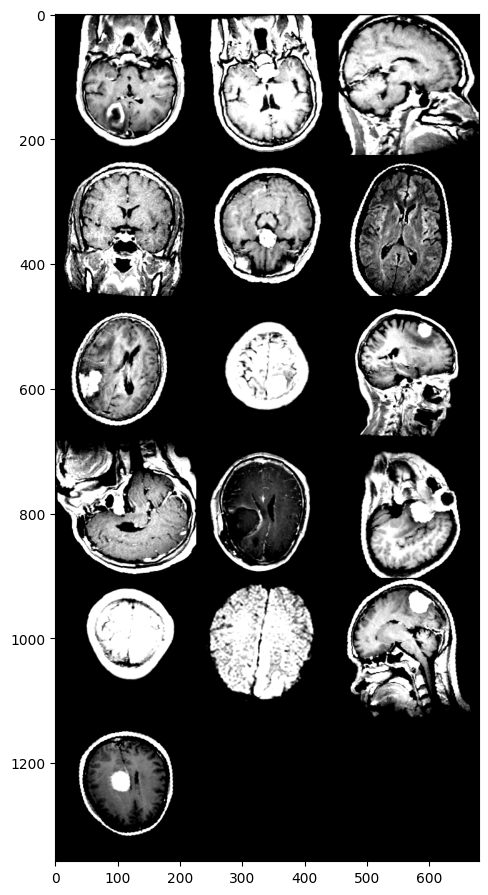

In [7]:
show_transformed_images(train_dataset)

----
# Setting up DenseNet
----

In [8]:
# DenseLayer / Convolutional Layer

class DenseLayer(nn.Module):
    def __init__(self,input_channels, growth_rate, bottle_neck_size, drop_rate, memory_efficient=False):
        super(DenseLayer, self).__init__()
        self.add_module('norm1',nn.BatchNorm2d(input_channels))
        self.add_module('relu1',nn.ReLU(inplace=True))
        self.add_module('conv1',nn.Conv2d(input_channels, bottle_neck_size * growth_rate,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bottle_neck_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2',nn.Conv2d(bottle_neck_size * growth_rate, growth_rate,
                                          kernel_size=3, stride=1, padding=1, bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        """Bottleneck Function"""
        '''type: (List[Tensor]) -> Tensor'''
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output

    def forward(self, input):
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        bottleneck_output = self.bn_function(prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)

        return new_features

In [9]:
# DenseBlock

class DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(self, num_layers, input_channels,bottle_neck_size, growth_rate, drop_rate, memory_efficient=False):
        super(DenseBlock, self).__init__()
        for i in range(num_layers):
            layers = DenseLayer(
                input_channels + i * growth_rate,
                growth_rate=growth_rate,
                bottle_neck_size=bottle_neck_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient)
            self.add_module('denselayer%d' % (i + 1), layers)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [10]:
# Transition Layers

class TransitionLayer(nn.Sequential):
    def __init__(self, input_channels, output_channels):
        super(TransitionLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(input_channels))
        self.add_module('relu',nn.ReLU(inplace=True))
        self.add_module('conv',nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=1, bias=False))
        self.add_module('pool',nn.AvgPool2d(kernel_size=2, stride=2))


In [11]:
class DenseNet121(nn.Module):

    def __init__(self, num_init_channels=64, growth_rate=32,
                 bottle_neck_size=4, drop_rate=0.0, num_classes=1000, memory_efficient=False):
        super(DenseNet121, self).__init__()

        # Initial Convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_channels, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_channels)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # DenseNet-121 Configuration
        block_config = [6, 12, 24, 16]

        num_features = num_init_channels

        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                input_channels=num_features,
                bottle_neck_size=bottle_neck_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            # The number of output channels in the previous dense block
            num_features = num_features + num_layers * growth_rate

            # A transition layer that halves the number of channels is added between the dense blocks
            if i != len(block_config) - 1:
                # Add transition layer between denseblocks to downsample
                trans = TransitionLayer(input_channels=num_features,
                                        output_channels=num_features // 2)
                self.features.add_module('Transition%d' % (i + 1), trans)
                num_features = num_features // 2


        # Final Batch Norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Fully connected layer
        self.classifier = nn.Linear(num_features, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

----
# Constructing the Model
----

In [12]:
def accuracy(y_pred, y_true):
    _, top_class = y_pred.topk(1, dim=1)  # Get the top class predictions directly from logits
    equals = top_class == y_true.view(*top_class.shape)  # Compare with true labels
    return torch.mean(equals.type(torch.FloatTensor))  # Calculate the mean accuracy

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet121(drop_rate=0.3, num_classes=4).to(device)
num_epochs = 50
optimizer=Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    train_acc /= len(train_dataset)
    train_accuracies.append(train_acc)

    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataset:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)

    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    test_acc /= len(test_dataset)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/50
Train Loss: 0.9405, Train Accuracy: 0.5995, Test Loss: 2.7887, Test Accuracy: 0.3360
Epoch 2/50
Train Loss: 0.8495, Train Accuracy: 0.6463, Test Loss: 4.6862, Test Accuracy: 0.3410
Epoch 3/50
Train Loss: 0.8138, Train Accuracy: 0.6626, Test Loss: 2.1759, Test Accuracy: 0.3410
Epoch 4/50
Train Loss: 0.7119, Train Accuracy: 0.7152, Test Loss: 2.4205, Test Accuracy: 0.3895
Epoch 5/50
Train Loss: 0.6758, Train Accuracy: 0.7308, Test Loss: 2.8410, Test Accuracy: 0.3790
Epoch 6/50
Train Loss: 0.6217, Train Accuracy: 0.7660, Test Loss: 1.8164, Test Accuracy: 0.4285
Epoch 7/50
Train Loss: 0.5636, Train Accuracy: 0.7706, Test Loss: 2.6874, Test Accuracy: 0.3580
Epoch 8/50
Train Loss: 0.5529, Train Accuracy: 0.7845, Test Loss: 1.9074, Test Accuracy: 0.5320
Epoch 9/50
Train Loss: 0.5131, Train Accuracy: 0.7959, Test Loss: 1.6985, Test Accuracy: 0.4970
Epoch 10/50
Train Loss: 0.5131, Train Accuracy: 0.8041, Test Loss: 1.7717, Test Accuracy: 0.4645
Epoch 11/50
Train Loss: 0.4722, Train A

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()